In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/model1'

Mounted at /content/drive
/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/model1


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector, Dropout, Input, Flatten,Concatenate
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import glob,os
import random
from keras.models import Model
import os,shutil

train_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/train1/'
val_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/val/'
test_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/test/'

In [4]:
# try axis =0 and 1; previously use 0
# add static variable to each time step -- pre-normalization not minmax -- negative value here for PCA scores
# read static
pca_score = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/pca_score.csv',index_col = 0)
# normalization -1 - 1 by each PC
temp2 = pca_score.values
temp_nor = preprocessing.normalize(temp2, norm='l2',axis = 1) # default for each column axis= 1 -- should normalize each feature
pca_score_nor = pd.DataFrame(temp_nor, index=[pca_score.index], columns=pca_score.columns)

In [ ]:
#########################NEW###################################
# add static variable to each time step -- pre-normalization not minmax -- negative value here for PCA scores
# read static
pca_score = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/cat_static.csv',index_col = 0)
# normalization -1 - 1 by each PC
temp2 = pca_score.values
temp_nor = preprocessing.normalize(temp2, norm='l2',axis = 1) # default for each column axis= 1
pca_score_nor = pd.DataFrame(temp_nor, index=[pca_score.index], columns=pca_score.columns)

In [ ]:
pca_score_nor

In [5]:
# dataset split
# import data for train, val and test

trainlist=os.listdir(train_path)
vallist=os.listdir(val_path)
testlist=os.listdir(test_path)

# all data should use this scaler--fit the scaler using all data
df2 = pd.DataFrame()
for j in range(len(trainlist)):
    data = pd.read_csv(train_path + trainlist[j], index_col = 0)
    df2 = pd.concat([df2,data],axis=0) 
temp = df2.values
min_max_scaler1 = MinMaxScaler() # default for each column
min_max_scaler1.fit(temp) # only fit--apply this to the sequence window for normalization

MinMaxScaler(copy=True, feature_range=(0, 1))

In [6]:
import keras.backend as K
def custom_regional_nse(y_true, y_pred):

  numerator = K.square(y_pred - y_true)  # (batch_size, 2)
  dominator = K.square(y_true - K.mean(y_true)) + 0.1
  # summing both loss values along batch dimension 
  numerator_sum = K.sum(numerator, axis=1)        # (batch_size,)
  dominator_sum = K.sum(dominator, axis=1)        # (batch_size,)
  loss = (numerator_sum)/(dominator_sum)
  return loss # automatical average along batch size when optimization

In [ ]:
# catchment static
# modified: only normalize the input instead of x and y
def split_regional_m2(static,path, dataset, n_input, n_output, scaler,shuffle): # add static table and select the repective variables
    x1, x2,y = list(),list(), list()
    for j in range(len(dataset)):
        data_1 = pd.read_csv(path + dataset[j], index_col = 0)
        data_2 = pd.read_csv(path + dataset[j], index_col = 0) # not normalize y(target)
        # MinMax for individual event
        sequence = scaler.transform(data_1)
        ####################27 catch##################
        #temp_static = np.zeros(( n_input + n_output,14))
        temp_static = np.zeros(( n_input + n_output,27))
        cat = dataset[j].split('-')[3]
        catchment = cat.split('.')[0]
        for i in range(temp_static.shape[1]):
            temp_static[i,:] = static[catchment].values
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix1 = i + n_input # runoff
            end_ix2 = i + n_input + n_output # others
            end_y = end_ix1 + n_output
            # check if we are beyond the sequence
            if end_ix1 > len(sequence):
                break
            if end_ix2 > len(sequence):
                break
            if end_y > len(sequence):
                break
            # gather input and output parts of the pattern
            temp_x2 = sequence[:,1:][i:end_ix2, :] # 3 rainfall, tmax and tmin -- add static to each time step
            seq_x1, seq_y = sequence[:,0][i:end_ix1], data_2.values[:,0][end_ix1:end_y] # 24 hours runoff and target runoff -- 0 to -1
            # concatnate temp_static and seq_x2

            seq_x2 = np.concatenate((temp_x2,temp_static), axis= 1) # axis= 0, row to row
            x1.append(seq_x1)
            x2.append(seq_x2)
            y.append(seq_y)

#shuffle
    x1, x2,y = np.array(x1), np.array(x2), np.array(y)
    number_list = np.arange(0,len(x1),1)
    random.shuffle(number_list) 
    x1_new = []
    for index in number_list:
        x1_new.append(x1[index])
    x2_new = []
    for index in number_list:
        x2_new.append(x2[index])
    y_new = []
    for index in number_list:
        y_new.append(y[index])
    if shuffle:
        return np.array(x1_new), np.array(x2_new), np.array(y_new)
    else:
        return x1,x2, y

In [7]:
# PCA
# modified: only normalize the input instead of x and y
def split_regional_m2(static,path, dataset, n_input, n_output, scaler,shuffle): # add static table and select the repective variables
    x1, x2,y = list(),list(), list()
    for j in range(len(dataset)):
        data_1 = pd.read_csv(path + dataset[j], index_col = 0)
        data_2 = pd.read_csv(path + dataset[j], index_col = 0) # not normalize y(target)
        # MinMax for individual event
        sequence = scaler.transform(data_1)
        ####################27 catch##################
        temp_static = np.zeros(( n_input + n_output,14))
        #temp_static = np.zeros(( n_input + n_output,27))
        cat = dataset[j].split('-')[3]
        catchment = cat.split('.')[0]
        for i in range(temp_static.shape[1]):
            temp_static[i,:] = static[catchment].values
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix1 = i + n_input # runoff
            end_ix2 = i + n_input + n_output # others
            end_y = end_ix1 + n_output
            # check if we are beyond the sequence
            if end_ix1 > len(sequence):
                break
            if end_ix2 > len(sequence):
                break
            if end_y > len(sequence):
                break
            # gather input and output parts of the pattern
            temp_x2 = sequence[:,1:][i:end_ix2, :] # 3 rainfall, tmax and tmin -- add static to each time step
            seq_x1, seq_y = sequence[:,0][i:end_ix1], data_2.values[:,0][end_ix1:end_y] # 24 hours runoff and target runoff -- 0 to -1
            # concatnate temp_static and seq_x2

            seq_x2 = np.concatenate((temp_x2,temp_static), axis= 1) # axis= 0, row to row
            x1.append(seq_x1)
            x2.append(seq_x2)
            y.append(seq_y)

#shuffle
    x1, x2,y = np.array(x1), np.array(x2), np.array(y)
    number_list = np.arange(0,len(x1),1)
    random.shuffle(number_list) 
    x1_new = []
    for index in number_list:
        x1_new.append(x1[index])
    x2_new = []
    for index in number_list:
        x2_new.append(x2[index])
    y_new = []
    for index in number_list:
        y_new.append(y[index])
    if shuffle:
        return np.array(x1_new), np.array(x2_new), np.array(y_new)
    else:
        return x1,x2, y

In [ ]:
pca_score_nor

In [8]:
# input for training model
train1_x, train2_x, train_y = split_regional_m2(pca_score_nor,train_path, trainlist, 24, 6,min_max_scaler1,shuffle =True)
#train1_x, train2_x, train_y = split_multi_sequence_keras(train_val, 24, 6,min_max_scaler1,shuffle =True)

# input for validation model -- using test
val1_x, val2_x, val_y = split_regional_m2(pca_score_nor,test_path, testlist, 24, 6, min_max_scaler1,shuffle =True)
#val1_x, val2_x, val_y = split_multi_sequence_keras(test, 24, 6, min_max_scaler1,shuffle =True)

val1_x = val1_x.reshape((val1_x.shape[0],val1_x.shape[1],1)) 
train1_x = train1_x.reshape((train1_x.shape[0],train1_x.shape[1],1))

In [11]:
# define customer optimizer
RMSprop=keras.optimizers.RMSprop(lr=0.0001)

# define special callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, cooldown=30, min_lr=1e-8)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2)
# design network
dim_dense=[512, 256, 256, 128, 64]

# input of runoff observation, LSTM encoder
input_1 = Input(shape=(train1_x.shape[1],train1_x.shape[2]), name='LSTM1_input') # shape should be 72*1 for runoff observation
LSTM1 = LSTM(256, return_sequences=False)(input_1)

# input of runoff observation and forecast, LSTM encoder
input_2 = Input(shape=(train2_x.shape[1],train2_x.shape[2]), name='LSTM2_input') # shape should be (72+24)*n=96*n, for rainfall observation (72) and predictions (24) for n stations (if there is no upstream station, n=1)
LSTM2 = LSTM(256, return_sequences=False)(input_2)

# input of other non-timeseries data, such as daily or monthly data.

# connect all data
x = Concatenate()([LSTM1, LSTM2]) # Get state vector.
x = RepeatVector(6)(x)  # 6 hour ahead

# LSTM decoder
x = LSTM(512, return_sequences=True)(x)

# final fully-connected layer for final result
for dim in dim_dense:
	x = TimeDistributed(Dense(dim, activation='relu'))(x)
	x = TimeDistributed(Dropout(0.4))(x) # Some dropout for dense layers.
main_out = TimeDistributed(Dense(1, activation='relu'))(x) 
main_out = Flatten()(main_out)

model = Model(inputs=[input_1, input_2], outputs=main_out)
#model.compile(optimizer=RMSprop, loss='mse') 
model.compile(optimizer=RMSprop, loss=custom_regional_nse) 
model.summary()

# fit network
history = model.fit([train1_x, train2_x], train_y, epochs=300, batch_size=32,
					validation_data=([val1_x, val2_x], val_y), callbacks=[reduce_lr,early_stopping], verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LSTM1_input (InputLayer)        [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
LSTM2_input (InputLayer)        [(None, 30, 17)]     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 256)          264192      LSTM1_input[0][0]                
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 256)          280576      LSTM2_input[0][0]                
____________________________________________________________________________________________

In [12]:
from keras.models import load_model
model.save('/content/drive/My Drive/master_thesis/_code/regional_model/model2_axis1_2.h5' ) # batch 32--11.10 -- version 2

In [13]:
model_rm2 = load_model('/content/drive/My Drive/master_thesis/_code/regional_model/model2_axis1_2.h5' , custom_objects={'custom_regional_nse': custom_regional_nse})

train_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/train/'
val_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/val/'
test_path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/test/'

# add static variable to each time step -- pre-normalization not minmax -- negative value here for PCA scores
# read static
pca_score = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/pca_score.csv',index_col = 0)
# normalization -1 - 1 by each PC
temp2 = pca_score.values
temp_nor = preprocessing.normalize(temp2, norm='l2',axis = 1) # default for each column axis= 1
pca_score_nor = pd.DataFrame(temp_nor, index=[pca_score.index], columns=pca_score.columns)

# import data for train, val and test

trainlist=os.listdir(train_path)
vallist=os.listdir(val_path)
testlist=os.listdir(test_path)

# all data should use this scaler--fit the scaler using all data
df2 = pd.DataFrame()
for j in range(len(trainlist)):
    data = pd.read_csv(train_path + trainlist[j], index_col = 0)
    df2 = pd.concat([df2,data],axis=0) 
temp = df2.values
min_max_scaler1 = MinMaxScaler() # default for each column
min_max_scaler1.fit(temp) # only fit--apply this to the sequence window for normalization

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
nse_table = pd.read_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/basin_name.csv',index_col = 0)
basins = nse_table.columns
from sklearn.metrics import r2_score 
for catchment in basins:
    path = '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/model1/%s_events/' % catchment

    file_all=os.listdir(path)
    file_all = sorted(file_all)
    split1 = int(len(file_all)*0.5) #
    train = file_all[:split1] # to folder train

    split2 = int(len(file_all)*0.75)  

    val = file_all[split1:split2] # to folder val

    test = file_all[split2:] # to folder test

    dataset = test
    ed_nse = []
    ed_hour = []
    ed_volume = []

    for j in range(len(dataset)):
        x1, x2,y = list(),list(), list()
        data_1 = pd.read_csv(path + dataset[j], index_col = 0)
        data_2 = pd.read_csv(path + dataset[j], index_col = 0) # not normalize y(target)
        # MinMax for individual event
        n_input = 24
        n_output = 6
        sequence = min_max_scaler1.transform(data_1)
        #####NEW CATCH 27#####
        temp_static = np.zeros(( n_input + n_output,14))
        #temp_static = np.zeros(( n_input + n_output,27))
        for i in range(temp_static.shape[1]):
            temp_static[i,:] = pca_score_nor[catchment].values
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix1 = i*n_output + n_input # runoff
            end_ix2 = i*n_output + n_input + n_output # others
            end_y = end_ix1 + n_output
            # check if we are beyond the sequence
            if end_ix1 > len(sequence):
                break
            if end_ix2 > len(sequence):
                break
            if end_y > len(sequence):
                break
            # gather input and output parts of the pattern
            temp_x2 = sequence[:,1:][i*n_output:end_ix2, :] # 3 rainfall, tmax and tmin -- add static to each time step
            seq_x1, seq_y = sequence[:,0][i*n_output:end_ix1], data_2.values[:,0][end_ix1:end_y] # 24 hours runoff and target runoff -- 0 to -1
            # concatnate temp_static and seq_x2

            seq_x2 = np.concatenate((temp_x2,temp_static), axis= 1) # axis= 0, row to row
            x1.append(seq_x1)
            x2.append(seq_x2)
            y.append(seq_y)

        x1 = np.array(x1)
        x2 = np.array(x2)
        y = np.array(y)

        predictions = []
        x1 = x1.reshape((x1.shape[0],x1.shape[1],1))
        predict = model_rm2.predict([x1,x2])
        predictions.append(predict)
        ed_nse.append(r2_score(np.array(y).flatten(), np.array(predictions).flatten()))
    nse_table[catchment] = np.median(ed_nse)

In [17]:
nse_table.to_csv( '/content/drive/My Drive/master_thesis/_code/regional_model/regional_data/rm2_axis1_2.csv')

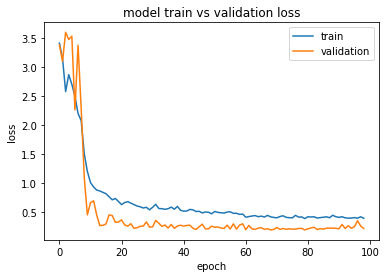

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title( 'model train vs validation loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend([ 'train', 'validation'], loc= 'upper right') 
plt.show()

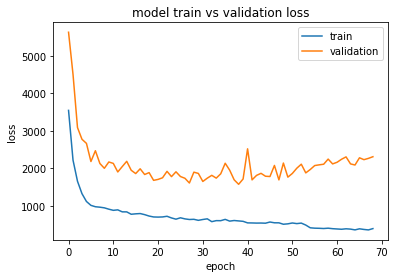

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title( 'model train vs validation loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend([ 'train', 'validation'], loc= 'upper right') 
plt.show()